# Why you should use Kriging

In this notebook, I will try to present various spatial estimation methods in multi-dimensions (here, for graphical needs, in dimension 2). My goal is to illustrate clearly how each works, his advantages and disadvantages. Lastly, I will present a method that I like very much : Kriging.

Note : this notebooks skips the entire theory behind each method. If you are curious, feel free to do some additional research.

I am trying to rely as few as possible on fancy packages, whose underlying code I am not sure of. Here are the tools you will need, which are some very common and widely used packages.

In [1]:
import numpy as np
np.random.seed(40643)
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern #,DotProduct, WhiteKernel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.interpolate import interp2d, interp1d

Warning : throughout this notebook, the graphical and numerical results may vary a lot depending on the random seed. It is important to set it once and for all before starting working. You can try to change it to see the impact (it is very immediate). However, it will not change the global conclusions of this work.

## Introduction

Suppose we have a 3D surface with the following equation :

In [2]:
def branin(x,y,a=1,b=5.1/(4*np.pi**2),c=5/np.pi,r=6,s=10,t=1/(8*np.pi)):
    return a*(y-b*x**2+c*x-r)**2+s*(1-t)*np.cos(x)+s

Some of you who have read a bit about optimization (https://en.wikipedia.org/wiki/Test_functions_for_optimization) will recognize it as the Branin function. It is commonly used, as many other functions, to test some optimization algorithms, since it is very strangely shaped with a lot of local minima everywhere, and three global minima (http://www.sfu.ca/~ssurjano/branin.html).

Let's plot it to get a better idea. Please note that, throughout all this notebook, everytime I want to plot something I use the scatter function *on purpose*. This is because with continuous plotting, matplotlib *interpolates* between your points, and since we are trying to study different estimation methods, that would be very untrustworthy. However, if you put enough points, it will always appear to be continuous to the viewer, so that is not a problem.

In [3]:
X=np.linspace(-5,10,1500)
Y=np.linspace(0,15,1500)
points=[(x,y) for y in Y for x in X]

In [4]:
Z=[branin(x,y) for (x,y) in points]
m=max(Z)
colors=cm.rainbow([z/m for z in Z])

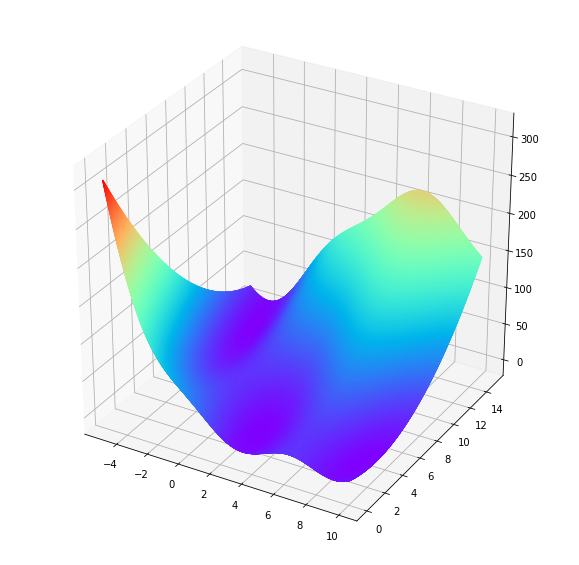

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([p[0] for p in points],[p[1] for p in points],Z, zdir='z', s=0.1, c=colors, depthshade=True)

Now, we will try various interpolation methods, to see which ones seem to approximate this function to the best. Let's randomly sample 100 points from our calculated points, and use them for fitting our interpolation. then we will try to recalculate all the others, and plot them.

In [5]:
coordinates=[(x,y,z) for x,y,z in zip([p[0] for p in points],[p[1] for p in points],Z)]
init_points=np.random.choice(len(coordinates),100)
X,y=np.asarray([points[i] for i in init_points]),[Z[i] for i in init_points]
X_test,y_test=np.asarray([points[i] for i in range(len(coordinates)) if i not in init_points]),[Z[i] for i in range(len(coordinates)) if i not in init_points]
# small=np.random.choice([i for i in range(len(coordinates)) if i not in init_points],100)
# X_test_small,y_test_small=np.asarray([points[i] for i in small]),[Z[i] for i in small]

Throughout this notebook, in addition to the graphics, we will need a suitable metrics to compare the different methods (that is to say, the "error" of each one with respect to the true values). Thereare a lot of possible metrics. I will choose the average mean squared error :

In [6]:
def mse(true,estim):
    loss=0
    for t,e in zip(true,estim):
        loss+=(t-e)**2
    loss=loss/len(true)
    return loss

We will also keep a dictionnary of the calculated errors, that will be useful for future comparisons.

In [7]:
dic_errors={'branin':0}

## Classical interpolation methods

### Linear interpolation

Let's start with the simplest of all methods : linear interpolation. It is very straightforward to implement using scipy (see here : https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.interp2d.html).

In [8]:
def interpol_2d(kind,X=X,y=y):
    fun=interp2d([x[0]for x in X],[x[1] for x in X],y,kind=kind)
    return fun

In [9]:
linear=interpol_2d('linear')
Z_linear=[linear(x[0],x[1]) for x in X_test[::2]]
Z_linear=np.concatenate(Z_linear)

C:\Users\lsfer\Anaconda3\envs\maps\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=14,11 m=100 fp=0.648120 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


What is the error of this method ?

In [10]:
dic_errors['linear']=mse(Z_linear,y_test[::2])
dic_errors

{'branin': 0, 'linear': 608.4748555186532}

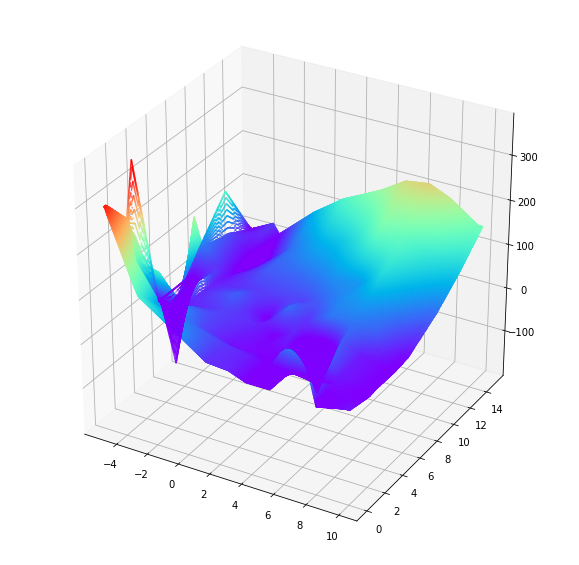

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_linear])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_linear, zdir='z', s=0.1, c=colors, depthshade=True)

We notice very well the "straightness" of linear interpolation : we can easily figure out where were the original points, and the curve is anything but smooth. Notice a big problem in this representation : we have some "layers", on top of each other, instead of a continuous surface.That is because we are plotting a lot of points, and sometimes the model doesn't choose well between which known points to interpolate. We will see int he second part of this notebook that, when you use less points, you don't meet this problem and the result is actually better. Anyway, it doesn't seem, in our case, a very appropriate interpolation method.

### Polynomial interpolation

A spline is a special function defined piecewise by polynomials. In interpolating problems, spline interpolation is often preferred to polynomial interpolation because it yields similar results, even when using low degree polynomials (from https://en.wikipedia.org/wiki/Spline_(mathematics)).

There are so many different types of polynomial interpolation that I will restrict myself to cubic splines (every piece is a polynomial of degree $\leq 3$).

In [11]:
cubic=interpol_2d('cubic')
Z_cubic=[cubic(x[0],x[1]) for x in X_test[::2]]
Z_cubic=np.concatenate(Z_cubic)
dic_errors['cubic_splines']=mse(Z_cubic,y_test[::2])
dic_errors

C:\Users\lsfer\Anaconda3\envs\maps\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=14,15 m=100 fp=0.000014 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


{'branin': 0, 'linear': 608.4748555186532, 'cubic_splines': 666461319.2028899}

Oh oh... Why is this error so massive compared to the linear error ? Let's take a look...

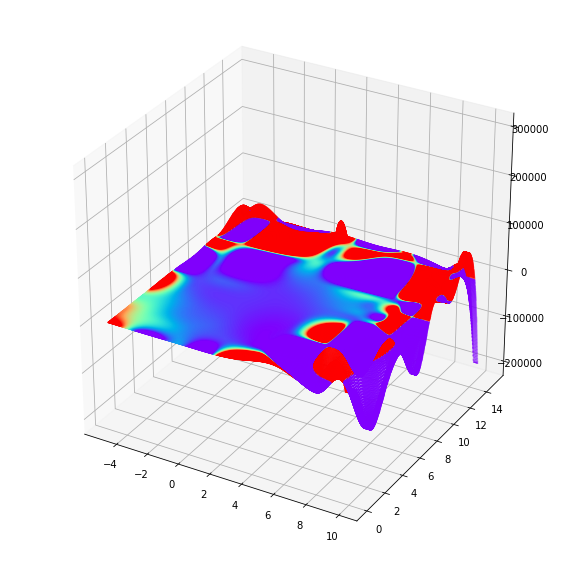

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_cubic])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_cubic, zdir='z', s=0.1, c=colors, depthshade=True)

Oh oh... What happened here ? Well, actually, this is a classical problem of polynomial interpolation (especially with a high degree, like cubic splines) : it explodes at the edges. If we set a maximum $z$ limit, we will see better :

(0, 300)

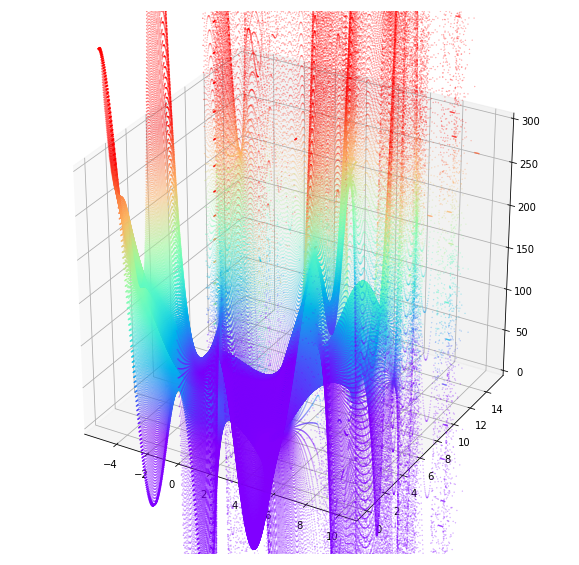

In [15]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_cubic])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_cubic, zdir='z', s=0.1, c=colors, depthshade=True)
ax.set_zlim(0, 300)

Oh oh... Definitely not a good idea, those splines. What is impressive when you think twice about it, is that the squared error on points at the edges must be (and is indeed) MASSIVE. However, interestingly, if you look closely we can see the actual polynomial curves between the interpolation points.

## Other methods

Here I present 2 methods who are not strictly speaking interpolation methods, but still widely used for space estimation.

### K-nearest-neighbors

I encourage you to test different values of n_neighbors, to see the difference in results. However, the conclusion remaines the same.

In [12]:
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X, y)
Z_knn=neigh.predict(X_test[::2])
dic_errors['knn'] = mse(Z_knn,y_test[::2])
dic_errors

{'branin': 0,
 'linear': 608.4748555186532,
 'cubic_splines': 666461319.2028899,
 'knn': 198.39958719921336}

Wow, a lot better ! Let's take a look.

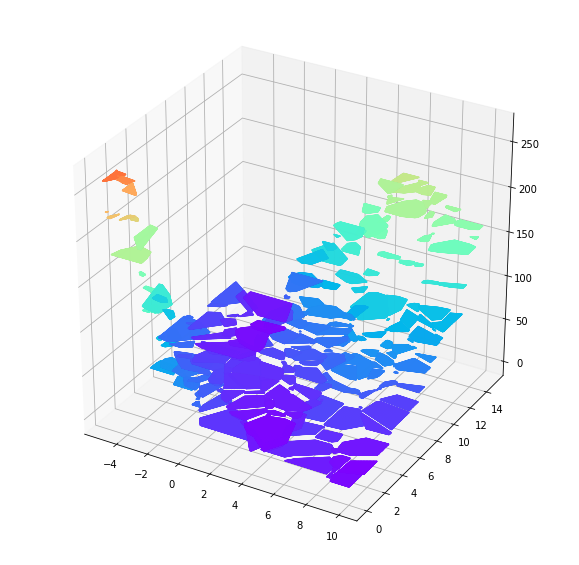

In [17]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_knn])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_knn, zdir='z', s=0.1, c=colors, depthshade=True)

We see here very well the fundamental property of k-nn : you can only take 100 Z-values, the ones from the initial points. You cannot get a continuous prediction. We very clearly see the patches surrounding the 100 original points, into which the data is approximated by the value at the central point.

### Random Forest Regression

Here as well, you can try various values for the number of trees, the maximal depth, or the metric.

In [13]:
regr = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=100, random_state=0)
regr.fit(X, y)
Z_randforest=regr.predict(X_test[::2])
dic_errors['random_forest'] = mse(Z_randforest,y_test[::2])
dic_errors

{'branin': 0,
 'linear': 608.4748555186532,
 'cubic_splines': 666461319.2028899,
 'knn': 198.39958719921336,
 'random_forest': 422.78498135585323}

Not as good as k-nn, but still a lot better than linear and splines interpolation.

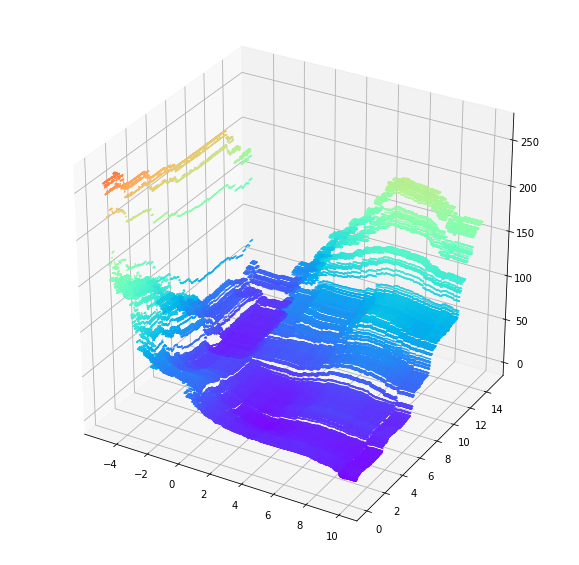

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_randforest])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_randforest, zdir='z', s=0.1, c=colors, depthshade=True)

Interestingly, we notice here a property of trees : we can see the presence of kind of strays, which are in fact linked to tree branches used in the attribution of value. They define "ranges" of values into which the attributed target is constant.

## Kriging

Here at last, I come to the most interesting part of this notebook ! For those of you who never heard about kriging, I recommend you to start with some theory.

Kriging is a very interesting and powerful interpolation methods, that can be used for various purposes : interpolation, smoothing (like presented here), but also in sequential experiments, in contexts of fixed calculation budgets (more detailed notebook on this subject coming soon), since it presents the advantage to estimate its own standard error in every point of space.

Be careful with Kriging : it is a gaussian process regressor, and has a random component. Luckily, scikit-learn uses the same seed as numpy, but don't forget to set it if you want your results to be reproducible.

Useful links :

https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process

https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor

I you didn't know (I didn't until quite recently), in lots of packages Kriging is actually called Gaussian Process Regressor.

In [14]:
kernel=Matern(length_scale=1,nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X, y)
print(gpr.score(X, y))

1.0


We get a score of 1, which is natural : kriging is an exact interpolation method, which means it goes exactly through the interpolation points. Like previously, I encourage you to try different kernels to see the results. There is not one perfect kernel for every function : the choice of kernel depends on what you are trying to estimate.

In [15]:
Z_krig=gpr.predict(X_test[::2], return_std=False)
dic_errors['kriging'] = mse(Z_krig,y_test[::2])
dic_errors

{'branin': 0,
 'linear': 608.4748555186532,
 'cubic_splines': 666461319.2028899,
 'knn': 198.39958719921336,
 'random_forest': 422.78498135585323,
 'kriging': 28.34356290423525}

Wow, great ! that's the model with the lowest error so far ! And by far !

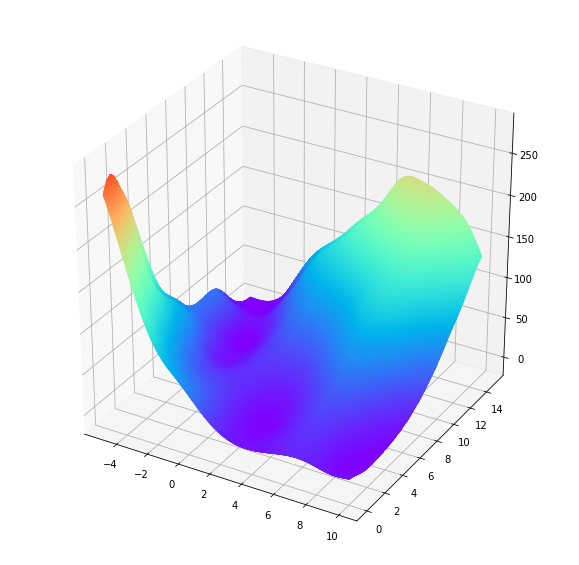

In [22]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_krig])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_krig, zdir='z', s=0.1, c=colors, depthshade=True)

Wow, so beautiful, so smooth ! And definitely much alike the original function. However, if you watch carefully, you can still notice areas where it is not very well estimated (for example the back corner). It still seems to be, by far, the best method so far.

 Let's take advantage of the kriging property of giving access to error, to see in which area the estimation is poorer :

In [16]:
Z_error=gpr.predict(X_test[::2], return_std=True)

In [17]:
Z_error=Z_error[1]

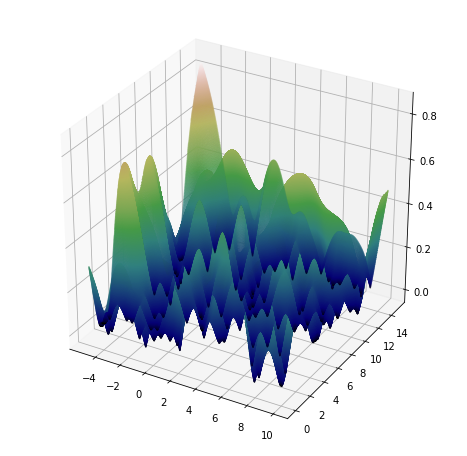

In [25]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
mm=max(Z_error)
colors=cm.gist_earth([z/mm for z in Z_error])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_error, zdir='z', s=0.1, c=colors, depthshade=True)

Like expected, the loss is particularly high in the back corner, but globally when you look at its range of values, it stays rather low compared to other methods.

## Conclusion

I don't want you to conclude from this notebook that you should always use Kriging, and that the other methods never work. Actually, there isn't one perfect method for every estimation problem. Please note that the function I have chosen, the Branin function, is a very peculiar function, often studied for its uncommon properties, that was a perfect example for this notebook. But on most simpler functions, the other methods can work as well, and sometimes even better than Kriging !

# A review of Sampling Methods and sequential simulations

In [50]:
np.random.seed(40643)

## Introduction

Here I will discuss two different problems. Let's imagine you are in a situation where *simulation is costly* : in computing time, in cost in case of physical experiments... Therefore, you have a given budget of 100 points to calculate, and you want to get the best possible estimation of your function or phenomenon in *all of the input space*. How do you choose them ? 

First, you noticed that throughout the first part I only focused on the interpolation methods and didn't talk about the 100 points I was working on. However, the way you choose them is of high importance ! There are several methods to sample points, some "more intelligent" than others.

Second, when you think about it, the main advantage of models that provide you a prediction error in all of the input space (like kriging does) is that you could use them for sequential simulations : you first choose a given number of points (rather small) to simulate, find where your error is the biggest, put a new simulation point there, reestimate your model, etc, until you have used all of your budget. Two questions come here : how many initial points do you take ? And what do you take for your next point, the one that has the biggest prevision error, or the one with the biggest prevision error in a specific region you are more interested in ?

## Sampling Methods

Let us keep track of errors :

In [51]:
dic_errors_grid={'branin' : 0}

### Grid sampling

Here I will give a quick example of why you should be very, very cautious if you use grid sampling. For recall, grid sampling consists of drawing a regular grid in your input space to select your points (entirely deterministic method). Let's just suppose for a moment that, instead of our rather regular Branin function, we are trying to estimate the following function :

In [27]:
def ackley(x,y=0):
    return -20*np.exp(-0.2*np.sqrt(0.5*(x**2 + y**2))) - np.exp(0.5*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y))) + np.exp(1) + 20

Some of you might have recognized the 2D-Ackley function, projected in the plane $y=0$. Let's plot it to get a quick idea.

#### Grid-sampling

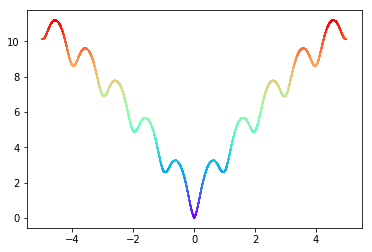

In [28]:
ackley_x=np.linspace(-5,5,100000)
ackley_y=[ackley(x) for x in ackley_x]
ackley_m=max(ackley_y)
colors=cm.rainbow([y/ackley_m for y in ackley_y])
plt.scatter(ackley_x,ackley_y,s=0.1,c=colors)

Now, let's suppose that we want to estimate this function with a regular grid between -5 and 5, of step 1.

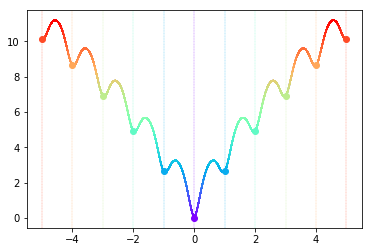

In [29]:
ackley_grid_x=np.linspace(-5,5,11)
ackley_grid_y=[ackley(x) for x in ackley_grid_x]
colors_2=cm.rainbow([y/ackley_m for y in ackley_grid_y])
plt.scatter(ackley_x,ackley_y,s=0.1,c=colors)
for x,y,c in zip(ackley_grid_x,ackley_grid_y,colors_2):
    plt.axvline(x=x,linestyle='--',linewidth=0.3,c=c)
#     plt.axhline(y=y,linestyle='--',linewidth=0.3,c=c)
    plt.plot(x,y,'o',c=c)

On this base, looking at the sampled points, anyone would easily do a simple linear or polynomial interpolation to estimate this model, and feel quite confident about it, whereas he is actually missing a lot of information about the true model.

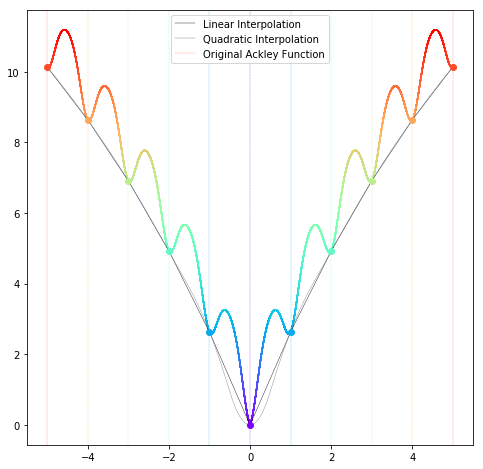

In [30]:
ackley_interp_linear=[interp1d(ackley_grid_x,ackley_grid_y,kind='linear')(x) for x in ackley_x]
ackley_interp_quadratic=[interp1d(ackley_grid_x,ackley_grid_y,kind='quadratic')(x) for x in ackley_x]
labels=['Linear Interpolation','Quadratic Interpolation','Original Ackley Function']
plt.figure(figsize=(8,8))
plt.scatter(ackley_x,ackley_y,s=0.1,c=colors)
plt.plot(ackley_x,ackley_interp_linear,'k',linewidth=0.4)
plt.plot(ackley_x,ackley_interp_quadratic,'slategray',linewidth=0.4)
for x,y,c in zip(ackley_grid_x,ackley_grid_y,colors_2):
    plt.axvline(x=x,linestyle='--',linewidth=0.3,c=c)
    plt.plot(x,y,'o',c=c)
plt.legend(labels)

This example helps me come to my point : with a regular grid, you often (not to say always) lose a loooot of information about your function. Only a random sampling can help you capture a better idea of the real behaviour of your function. To sums things up, you should never, ever, use a regular grid to estimate a function you are not sure of (or at least, you should always add random points in addition to the regular grid). However, in practice, you will often find that grid sampling often works well for not bad-behaved functions. Therefore it is a method that you should of course consider, but with high caution.

Now let's come back to our 2D-Branin function. In our case, grid sampling does actually work rather well. Let's do just a simple linear interpolation first :

In [52]:
grid_x=np.linspace(-5,10,10)
grid_y=np.linspace(0,15,10)
points_grid = [(x,y) for x in grid_x for y in grid_y]
branin_grid=[branin(x,y) for x in grid_x for y in grid_y]

In [53]:
linear=interpol_2d('linear',X=points_grid,y=branin_grid)
Z_linear=[linear(x[0],x[1]) for x in X_test[::2]]
Z_linear=np.concatenate(Z_linear)
dic_errors_grid['linear'] = round(mse(Z_linear,y_test[::2]),2)
dic_errors_grid

{'branin': 0, 'linear': 10.21}

You can notice that the linear model seems to work better on a regular grid than on semi-random points like in the first part. Be careful about that conclusion : first, if you remember how we constructed the 100 points of first part, we first drew a regular grid of $1500\times 1500= \text{more than 2 million points}$, and then randomly selected 100 points within this ensemble. And the only thing worse than a regular grid, is an incomplete regular grid. Furthermore, our function has some nice regularity. However, keep in mind that it is not necessarily the case in a more general framework.

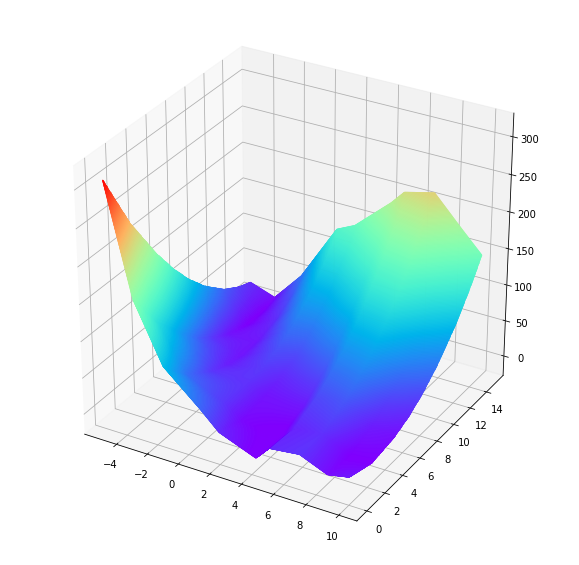

In [33]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_linear])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_linear, zdir='z', s=0.1, c=colors, depthshade=True)

Well, not so bad ! But it still lacks some smoothness. Looking at the edges of the surface, we can easily guess where the grid points are located (at the angles). Now trying with Kriging :

In [54]:
kernel=Matern(length_scale=1,nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(points_grid, branin_grid)
krig=gpr.predict(X_test[::2], return_std=True)
Z_krig,Z_error=krig[0],krig[1]
dic_errors_grid['kriging'] = round(mse(Z_krig,y_test[::2]),2)
dic_errors_grid

{'branin': 0, 'linear': 10.21, 'kriging': 9.48}

Kriging also seems to work better on this regular grid than in the semi-random points of first part (see my explanation above). It is better than the linear model.

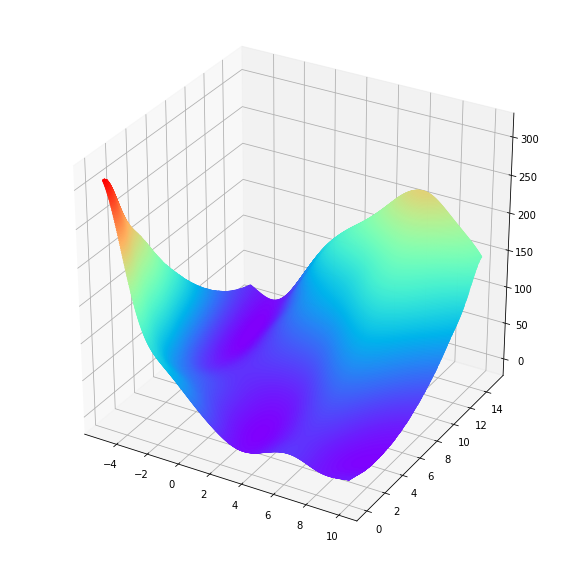

In [35]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_krig])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_krig, zdir='z', s=0.1, c=colors, depthshade=True)

Better than with linear interpolation... Let's now take a look at the error :

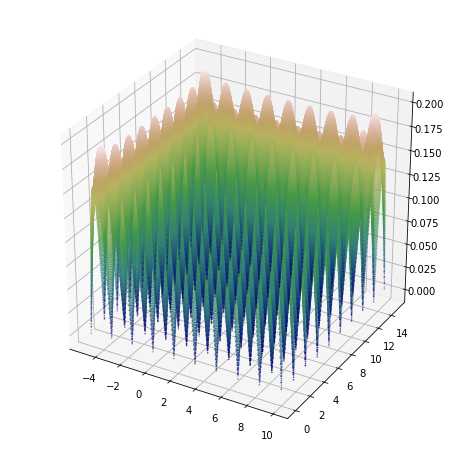

In [36]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
max_error=max(Z_error)
colors=cm.gist_earth([z/max_error for z in Z_error])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_error, zdir='z', s=0.1, c=colors, depthshade=True)

The error is very symetrical, contrary to the previous one we had on random points. It also has a lower amplitude.

### Pure Monte-Carlo

Now that you are convinced that you should not use grid-sampling, let's investigate random sampling methods. There are a loooot of them, I will only present some of the most common ones. Let's go from the *randomest* one to the most deterministic ones.

The first, very natural random sampling method is pure Monte-Carlo : you completely randomly, uniformly select points in your input space, independently of each other. Please note that this method is the only one from all presented sampling methods, including grid-sampling, to be independent from the total number of points selected.

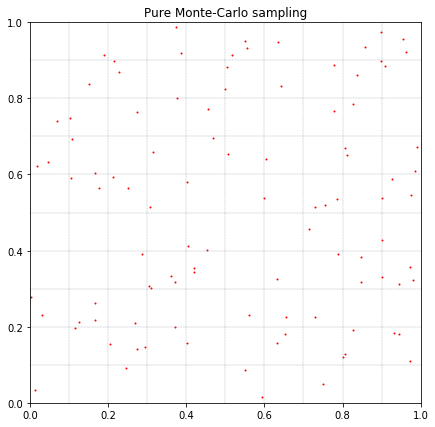

In [55]:
X=np.random.random(100)
Y=np.random.random(100)
plt.figure(figsize=(7,7))
plt.plot(X,Y,'ro',markersize=1)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Pure Monte-Carlo sampling')
for i in np.linspace(0,1,11)[1:10]:
    plt.axvline(x=i,linestyle='--',linewidth=0.3,c='slategray')
    plt.axhline(y=i,linestyle='--',linewidth=0.3,c='slategray')

The points are very heterogeneously distributed : some squares have no point in them, some have two, three or even more. With an affine transformation we can adapt those points to the input space of our Branin function :

In [56]:
X=[15*x-5 for x in X]
Y=[15*y for y in Y]
points_mc=[(x,y) for x,y in zip(X,Y)]
branin_mc=[branin(x,y) for x,y in zip(X,Y)]

In [57]:
dic_errors_mc={'branin':0}

In [58]:
linear=interpol_2d('linear',X=points_mc,y=branin_mc)
Z_linear=[linear(x[0],x[1]) for x in X_test[::2]]
Z_linear=np.concatenate(Z_linear)
dic_errors_mc['linear'] = round(mse(Z_linear,y_test[::2]),2)
# print(f'Errors on grid sampling : {dic_errors_grid}')
# print(f'Errors on pure Monte-Carlo sampling : {dic_errors_mc}')

C:\Users\lsfer\Anaconda3\envs\maps\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=14,11 m=100 fp=1.047379 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [34]:
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')
# colors=cm.rainbow([z/m for z in Z_linear])
# ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_linear, zdir='z', s=0.1, c=colors, depthshade=True)

And now with Kriging :

In [59]:
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(points_mc, branin_mc)
krig=gpr.predict(X_test[::2], return_std=True)
Z_krig,Z_error=krig[0],krig[1]
dic_errors_mc['kriging'] = round(mse(Z_krig,y_test[::2]),2)
print(f'Errors on grid sampling : {dic_errors_grid}')
print(f'Errors on pure Monte-Carlo sampling : {dic_errors_mc}')

Errors on grid sampling : {'branin': 0, 'linear': 10.21, 'kriging': 9.48}
Errors on pure Monte-Carlo sampling : {'branin': 0, 'linear': 836.18, 'kriging': 32.22}


In [ ]:
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')
# colors=cm.rainbow([z/m for z in Z_krig])
# ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_krig, zdir='z', s=0.1, c=colors, depthshade=True)

In our case, pure Monte-Carlo doesn't seem to be a better sampling method than grid-sampling.

### Stratified Hypercube Sampling

We have seen that pure random sampling is far from perfect. The main problem is what makes the strength of grid sampling : spatial homogeneity. Let's try to get the best of both methods in order to get better sampling.

The idea of stratified hypercube sampling is the following : you divide your input space into *n* regular hypercubes (in our case, squares). Then, in each hypercube, you uniformly sample one and only one point. The result is still random, but more regularly distributed.

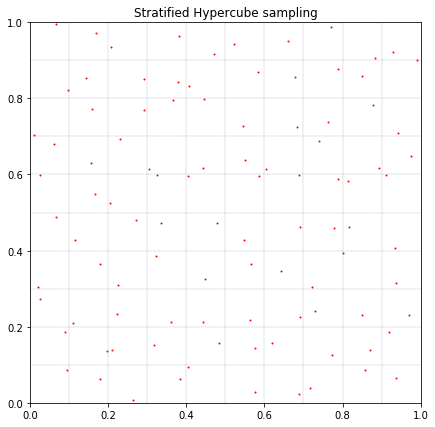

In [60]:
X=[0.1*(np.random.random()+i) for i in range(10) for j in range(10)]
Y=[0.1*(np.random.random()+j) for i in range(10) for j in range(10)]
plt.figure(figsize=(7,7))
plt.plot(X,Y,'ro',markersize=1)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Stratified Hypercube sampling')
for i in np.linspace(0,1,11)[1:10]:
    plt.axvline(x=i,linestyle='--',linewidth=0.3,c='slategray')
    plt.axhline(y=i,linestyle='--',linewidth=0.3,c='slategray')

You can check that each of the 100 subsquares has one and only one point in it, randomly sampled.

In [61]:
X=[15*x-5 for x in X]
Y=[15*y for y in Y]
points_hs=[(x,y) for x,y in zip(X,Y)]
branin_hs=[branin(x,y) for x,y in zip(X,Y)]
dic_errors_hs={'branin':0}
linear=interpol_2d('linear',X=points_hs,y=branin_hs)
Z_linear=[linear(x[0],x[1]) for x in X_test[::2]]
Z_linear=np.concatenate(Z_linear)
dic_errors_hs['linear'] = round(mse(Z_linear,y_test[::2]),2)
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(points_hs, branin_hs)
krig=gpr.predict(X_test[::2], return_std=True)
Z_krig,Z_error=krig[0],krig[1]
dic_errors_hs['kriging'] = round(mse(Z_krig,y_test[::2]),2)
print(f'Errors on grid sampling : {dic_errors_grid}')
print(f'Errors on pure Monte-Carlo sampling : {dic_errors_mc}')
print(f'Errors on stratified hypercube sampling : {dic_errors_hs}')

Errors on grid sampling : {'branin': 0, 'linear': 10.21, 'kriging': 9.48}
Errors on pure Monte-Carlo sampling : {'branin': 0, 'linear': 836.18, 'kriging': 32.22}
Errors on stratified hypercube sampling : {'branin': 0, 'linear': 326.58, 'kriging': 91.61}


On stratified hypercube sampling, we get better results than in pure Monte-Carlo for linear interpolation, but worse for kriging. However, be careful not to draw hastened conclusions : it depends a LOT on the random seed...

### Latin Hypercube Sampling

Latin Hypercube sampling is considered one of the best possible sampling methods. It is a random sampling method that also has some nice homogeneity properties. The idea is the following : your input-space is a kind of chessboard with *n* columns and *n* lines, *n* being the number of points you want to sample. You will put your points as if they were rooks not threatening each other (https://en.wikipedia.org/wiki/Latin_hypercube_sampling).

In continuous sampling, you of course uniformly choose a point in each cell you selected. From a more practical point of view, one possible construction method is to regularly divide your input space into *n* columns and *n* lines, uniformly sample a point into each of the *n* diagonal cells, and then shuffle the lines OR rows. Let's get a visual explanation.

First step : we construct the *n* diagonal cells, and uniformly sample a point in each :

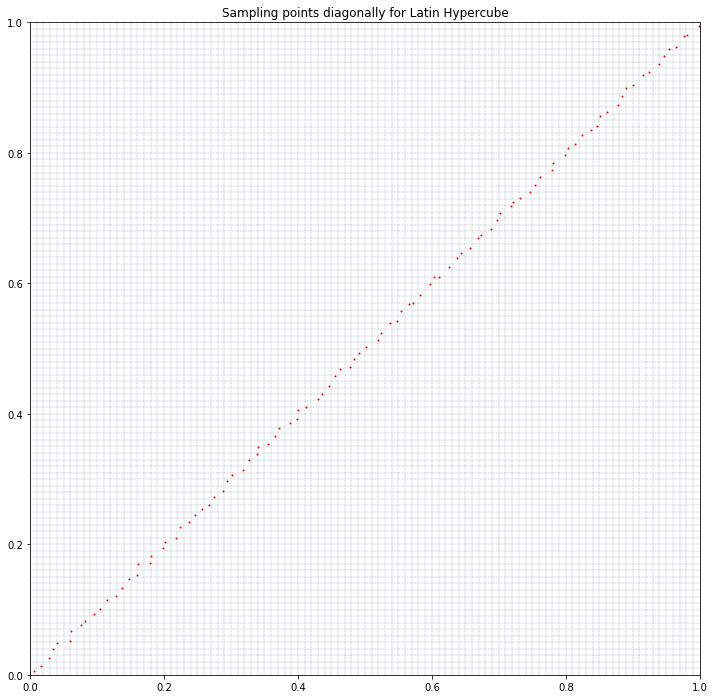

In [62]:
X=[0.01*(np.random.random()+i) for i in range(100)]
Y=[0.01*(np.random.random()+j) for j in range(100)]
plt.figure(figsize=(12,12))
plt.plot(X,Y,'ro',markersize=1)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Sampling points diagonally for Latin Hypercube')
for i in np.linspace(0,1,101)[1:100]:
    plt.axvline(x=i,linestyle='--',linewidth=0.3,c='slategray')
    plt.axhline(y=i,linestyle='--',linewidth=0.3,c='slategray')

Note that this is in fact a valid, particular, rather shitty example of latin hypercube : if your points were rooks on a giant chessboard, they would indeed not threaten each other. But let's get it better by shuffling the columns :

In [63]:
columns=np.arange(100)
np.random.shuffle(columns)
def message(i):
    print(f'The point in cell {(i,i)} will be moved to cell {(columns[i],i)}')
for i in range(3):
    message(i)

The point in cell (0, 0) will be moved to cell (87, 0)
The point in cell (1, 1) will be moved to cell (29, 1)
The point in cell (2, 2) will be moved to cell (28, 2)


 Warning : the position of the point inside the cell will remain unchanged ! It is a simple translation.

In [64]:
for i in range(100):
    X[i]=X[i]-0.01*i+0.01*columns[i]

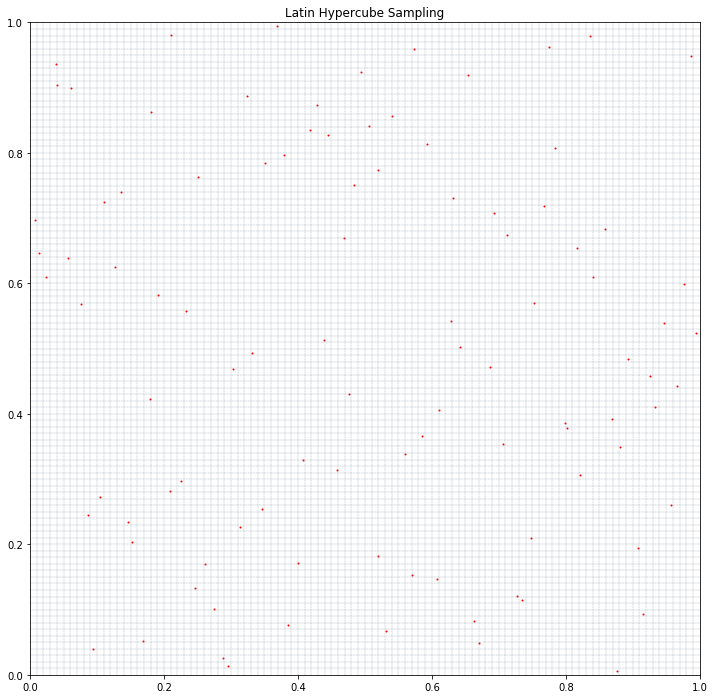

In [65]:
plt.figure(figsize=(12,12))
plt.plot(X,Y,'ro',markersize=1)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Latin Hypercube Sampling')
for i in np.linspace(0,1,101)[1:100]:
    plt.axvline(x=i,linestyle='--',linewidth=0.3,c='slategray')
    plt.axhline(y=i,linestyle='--',linewidth=0.3,c='slategray')

If you try to follow the points *horizontally*, you can indeed see that their position in each little square didn't change. This configuration is both more random and more homogeneous than stratified hypercube sampling. Let's see what we get with our Branin function.

In [66]:
X=[15*x-5 for x in X]
Y=[15*y for y in Y]
points_lhs=[(x,y) for x,y in zip(X,Y)]
branin_lhs=[branin(x,y) for x,y in zip(X,Y)]
dic_errors_lhs={'branin':0}
linear=interpol_2d('linear',X=points_lhs,y=branin_lhs)
Z_linear=[linear(x[0],x[1]) for x in X_test[::2]]
Z_linear=np.concatenate(Z_linear)
dic_errors_lhs['linear'] = round(mse(Z_linear,y_test[::2]),2)
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(points_lhs, branin_lhs)
krig=gpr.predict(X_test[::2], return_std=True)
Z_krig,Z_error=krig[0],krig[1]
dic_errors_lhs['kriging'] = round(mse(Z_krig,y_test[::2]),2)
print(f'Errors on grid sampling : {dic_errors_grid}')
print(f'Errors on pure Monte-Carlo sampling : {dic_errors_mc}')
print(f'Errors on stratified hypercube sampling : {dic_errors_hs}')
print(f'Errors on latin hypercube sampling : {dic_errors_lhs}')

C:\Users\lsfer\Anaconda3\envs\maps\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=12,13 m=100 fp=0.865528 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


Errors on grid sampling : {'branin': 0, 'linear': 10.21, 'kriging': 9.48}
Errors on pure Monte-Carlo sampling : {'branin': 0, 'linear': 836.18, 'kriging': 32.22}
Errors on stratified hypercube sampling : {'branin': 0, 'linear': 326.58, 'kriging': 91.61}
Errors on latin hypercube sampling : {'branin': 0, 'linear': 47029.84, 'kriging': 101.92}


A good sampling method is all about theory ! In practice, it depends a lot on your model. Here we see that latin hypercube sampling doesn't seem to work well.

### Conclusion

We have reviewed four sampling methods : deterministic grid sampling, pure Monte-Carlo, stratified hypercubes, and latin hypercube. Each has its qualities and disadvantages. In the end, it all depends on the function you are trying to estimate, even though we were able to draw some general conclusions on the properties of each. But more importantly, it depends a lot on the *number of points you are sampling*. Here we have sampled 100 points, what in dimension 2 is quite a high number of points. In the next part, you will see the results when we draw a much lower number of points.

## Sequential simulations for Kriging

In [71]:
np.random.seed(40643)

We will now try to get a better strategy : instead of drawing all our points first in one shot, and then estimating our function on them, we will use the interesting Kriging property of having access to the estimated error of the model in every point of the input space. We will first draw some points one-shot through one of the above methods, let's say a quarter of our total budget, and estimate our Kriging model on it.

In [68]:
def grid_sampling(n):
    X=np.linspace(-5,10,int(np.sqrt(n)))
    Y=np.linspace(0,15,int(np.sqrt(n)))
    return [(x,y) for x in X for y in Y]

def monte_carlo(n):
    return [(15*np.random.random()-5,15*np.random.random()) for _ in range(n)]

def stratified_hypercube(n):
    X=[(15./int(np.sqrt(n)))*(i+np.random.random()) -5 for i in range(int(np.sqrt(n))) for j in range(int(np.sqrt(n)))]
    Y=[(15./int(np.sqrt(n)))*(j+np.random.random()) for i in range(int(np.sqrt(n))) for j in range(int(np.sqrt(n)))]
    return [(x,y) for x,y in zip(X,Y)]
    
def latin_hypercube(n):
    X=[]
    Y=[(15./n)*(i+np.random.random()) for i in range(n)]
    cols=np.arange(n)
    np.random.shuffle(cols)
    for i in range(n):
        X.append((15./n)*(cols[i]+np.random.random()) -5)
    return [(x,y) for x,y in zip(X,Y)]

def kriging(points,kernel=kernel):
    b=[branin(t[0],t[1]) for t in points]
    gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(points, b)
    krig=gpr.predict(X_test[::2], return_std=True)
    return krig

In [74]:
n_init=25
errors={}
max_error=0
for method in [grid_sampling,monte_carlo,stratified_hypercube,latin_hypercube]:
#     print(f'Sampling initial points following {method.__name__} method')
    points=method(n_init)
    krig=kriging(points)
    errors[method] = krig[1]
    if max(errors[method])>max_error:
        max_error=max(errors[method])

In [78]:
# for method in [grid_sampling,monte_carlo,stratified_hypercube,latin_hypercube]:
#     fig = plt.figure(figsize=(8,8))
#     fig.suptitle(f'Estimated kriging error in the input space when estimating {n_init} points by {method.__name__}')
#     ax = fig.add_subplot(111, projection='3d')
#     colors=cm.gist_earth([z/max_error for z in errors[method]])
#     ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]], errors[method], zdir='z', s=0.1, c=colors, depthshade=True)
#     plt.show()

In [76]:
def sequential_kriging(n_init,n_total,method,kernel=kernel):
    points=method(n_init)
    errors=[]
    for _ in range(n_total-n_init):
        krig=kriging(points,kernel)
        next_point,error = np.argmax(krig[1]), max(krig[1])
        errors.append(error)
        points.append(X_test[2*next_point])
    krig=kriging(points,kernel)
    return krig,errors

In [ ]:
n_total=100
errors={}
for method in [grid_sampling,monte_carlo,stratified_hypercube,latin_hypercube]:
#     fig = plt.figure(figsize=(8,8))
#     fig.suptitle(f'Estimated Kriging error at the end of a {n_total} sequential points estimation with {n_init} initial points sampled by {method.__name__}')
#     ax = fig.add_subplot(111, projection='3d')
    krig,_ = sequential_kriging(n_init,n_total,method,kernel)
    Z_krig,Z_error=krig[0],krig[1]
    errors[method.__name__]=round(mse(Z_krig,y_test[::2]),2)
    print(f'Final estimation error for {n_total} points sequential kriging with {n_init} initial points sampled by {method.__name__} : {errors[method.__name__]}')
#     colors=cm.gist_earth([z/max_error for z in Z_error])
#     ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]], Z_error, zdir='z', s=0.1, c=colors, depthshade=True)
#     plt.show()